# goal of this notebook

The purpose of this notebook will be to look at the most recent layers run and for any given basin and timestep define:

- the G terms
- the M term
- The J terms distribution

# import packages

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# Define mask and timesteps

In [2]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/BarentsS_paper/figs/"
dirLayers = layers_path + "diags/LAYERS/"
dirLayersCwet = layers_path + "diags/LAYERS_Cwet/"
dirState = layers_path + "diags/STATE/"
dirgridw = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [3]:
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

In [4]:
def get_season_months(year, season,test):
    """Return months corresponding to a season for a given year."""
    seasons = {
        "DJF": [12, 1, 2, 3],  # December (previous year), January, February
        "MAM": [3, 4, 5, 6],    # March, April, May
        "JJA": [6, 7, 8, 9],    # June, July, August
        "SON": [9, 10, 11, 12]   # September, October, November
    }

    if season not in seasons:
        raise ValueError(f"Invalid season: {season}. Choose from 'DJF', 'MAM', 'JJA', 'SON'.")

    months = np.array(seasons[season])

    # Handle DJF spanning two years
    if test == True:
        times = {str(year): np.array([1,2,3,4])}
    elif season == "DJF":
        times = {str(year - 1): np.array([12]), str(year): np.array([1, 2, 3])}
    else:
        times = {str(year): months}

    return times

test = True # for JFM

# Example usage:
times = get_season_months(2007, "DJF",test)
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

{'2007': array([1, 2, 3, 4])}


2678400.0

In [5]:
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(2,13,1)
times['2008'] = np.array([1])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

{'2007': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), '2008': array([1])}


array(['0000267408', '0000271440', '0000275904', '0000280224',
       '0000284688', '0000289008', '0000293472', '0000297936',
       '0000302256', '0000306720', '0000311040', '0000315504'],
      dtype='<U32')

In [6]:
# define mask -- we can use mskBasin or the square mask that we did in the previous version
# load another mask
mymsk = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Lind2018/mask_Lind.npz')
mymsk = mymsk['msk1']

# Using np.where to get indices where the mask equals 1
rows, cols = np.where(mymsk == 1)

# Get the extreme indices in each dimension
min_row, max_row = rows.min(), rows.max()
min_col, max_col = cols.min(), cols.max()

print("Bottom edge (min row index):", min_row)
print("Top edge (max row index):", max_row)
print("Left edge (min col index):", min_col)
print("Right edge (max col index):", max_col)

mask = np.zeros_like(mymsk)
# max_row -=15
# max_col -=15
mask[min_row:max_row,min_col:max_col] = 1
mask[mask == 0] = np.nan
msk_tobin = mask.copy()

mymsk = mask

Bottom edge (min row index): 524
Top edge (max row index): 552
Left edge (min col index): 34
Right edge (max col index): 58


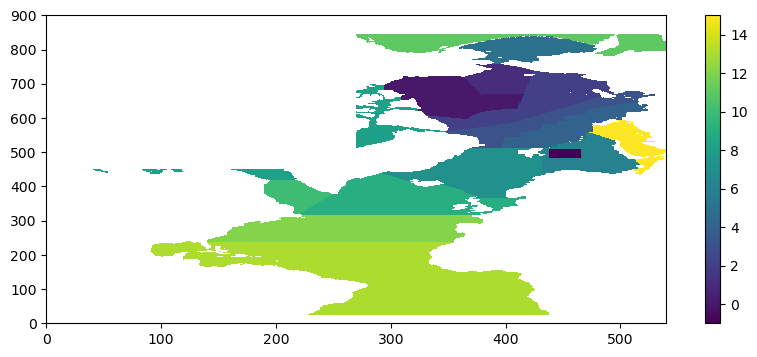

In [7]:
# do another mask with mymsk so we can look at this
mskBasin[mymsk == 1] = -1

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == -1)[0]

In [8]:
iwet_mine = iwet_BarentsS2D

# Import the T-S bins

In [9]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbincentp,Sbincentp = np.meshgrid(binmidTp,binmidSp)
nS,nT = 112,112

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

In [10]:
# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (146614,)
(4833023,)


# Import the volume distribution

In [11]:
name = "Lind_msk"
name = "BarentsS"

In [12]:
tsstr

array(['0000267408', '0000271440', '0000275904', '0000280224',
       '0000284688', '0000289008', '0000293472', '0000297936',
       '0000302256', '0000306720', '0000311040', '0000315504'],
      dtype='<U32')

In [13]:
dirLayersCwet

'/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS_Cwet/'

In [14]:
# Try to read the volume from the layers
# Now create vectors (366) - this is not correct I think
vol_distrib = {}
dT, dS = np.meshgrid(binwidthT, binwidthS)
i = 1

for ts in tsstr[1:]:
    print(ts)
    filename = dirLayersCwet + "layers_TSjoint_p_" + str(LwetC2d) + "." + ts + ".data"
    tmp = read_float32_skip(filename, LwetC2d * (nS) * (nT), i - 1)

    tmp = np.reshape(tmp, (nT, nS, LwetC2d))  # LwetC2d x nS x nT
    small = rac2d * hf2d
    small = np.tile(small[np.newaxis, np.newaxis, :], (nT, nS, 1))

    tmp = tmp * small * ffac

    # Do just for BarentsS
    tmp1 = np.nansum(tmp[:, :, iwet_mine], axis=2)
    tmp1[tmp1 == 0] = np.nan
    vol_distrib[ts] = tmp1 / dT / dS  # [m^3 / (degC psu)]

    del tmp1


0000271440
0000275904
0000280224


KeyboardInterrupt: 

In [21]:
dt

2678400.0

(-2.0, 10.0)

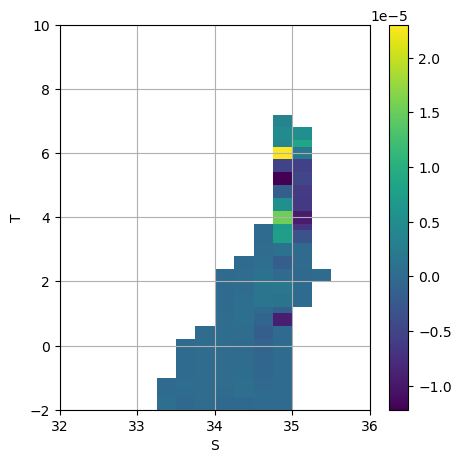

In [22]:
# # make a quick volume distribution of the entire region
plt.figure(figsize = (5,5))
plt.pcolormesh(Sbin,Tbin,(vol_distrib['0000271440'] - vol_distrib['0000275904']).T/2678400.0*1e-6)
plt.colorbar()
plt.xlabel("S")
plt.ylabel("T")
plt.grid()
plt.xlim(32,36)
plt.ylim(-2,10)

# Define the G terms

In [14]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + str(tsstr[-1])+ ".meta")
metaS=parsemeta(layers_path + "diags/LAYERS/layers_3d_Stend." + str(tsstr[-1])+ ".meta")
nFldsS = metaS["fldList"]
nFldsT = metaT["fldList"]
print(len(nFldsS))
print(len(nFldsT))
setTtend=nFldsT.copy()
setStend=nFldsS.copy()

24
24


In [15]:
# check for the correct diagnostics
metaS['fldList']
a = metaS['fldList']
# print(a[12],a[13],a[14],a[19],a[20],a[23])  # surf 
ifldS = np.array([12,13,14,19,20,23])  # total tend, surf, hDiff, vDiff, hADV, vADV

metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
# print(b[0],b[1],b[2],b[7],b[8],b[11])
ifldT = np.array([0,1,2,7,8,11])    # surf, hDiff, vDiff, hADV, vADV, total tend

print(np.array(a)[ifldS]) # for G_S
print()
print(np.array(b)[ifldT]) # for G_T

['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']


In [16]:
# make the G_T term
G_T = {}
G_T[name] = {}
    
# now loop through
for ts in tsstr[1:2]:
    G_T[name][ts] = {}
    for i in range(len(ifldT)-1, -1, -1):
        tmp = read_float32_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
        tmp = np.reshape(tmp,(nT-1,nx*ny))
        tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
        if i == ifldT.shape[0]-1:
            # if LTto2TH, do not remove from residual
            residT = tmp
        else:
            # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
            residT = residT-tmp
    
        # just do the Barents Sea for this one
        a = np.nansum(tmp[:,iwet_mine],axis=1)
        G_T[name][ts][setTtend[ifldT[i]]] = a

    G_T[name][ts]["residT"] = np.nansum(residT[:,iwet_mine],axis=1)

In [17]:
G_T

{'BarentsS': {'0000271440': {'LTto2TH': array([ 0.00000000e+00, -1.03403745e-02, -7.38789196e-01, -1.08978247e+00,
          -1.48241274e+00, -1.71266513e+00, -2.10082422e+00, -2.55020668e+00,
          -2.90415714e+00, -3.05291490e+00, -1.83309445e+00, -2.12053300e+00,
          -3.55146559e+00, -5.13251739e+00, -4.56494507e+00, -4.32258645e+00,
          -5.05350412e+00, -5.44967071e+00, -4.66973931e+00, -3.34134157e+00,
          -2.70545391e+00, -2.36925633e+00, -1.94754739e+00, -2.38728747e+00,
          -2.94602061e+00, -5.32975247e+00, -4.40007348e+00, -2.04248071e+00,
          -7.16109740e-01, -1.62974848e-03,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, 

In [ ]:
# create G_S for all basins (line 258)
G_S = {}
G_S[name] = {}

# now loop through similar to ifldS
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float32_skip(layers_path + "diags/LAYERS/layers_3d_Stend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldS.shape[0]-1:
        # if LSto1SLT, do not remove from residual, this is the total tendency
        residS = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residS = residS-tmp

    # just do for the Barents Sea
    a = np.nansum(tmp[:,iwet_mine],axis=1)
    G_S[name][setStend[ifldS[i]]] = a

# loop through again to calculate resid
G_S[name]["residS"] = np.nansum(residS[:,iwet_mine],axis=1)

In [ ]:
# this will be the reverse of what we read ifldT definition
G_S[name].keys()
G_T[name].keys()

In [ ]:
# get the edges for the array
iiS = np.where(G_S[name]["LSto1SLT"] != 0)[0]
iiS = np.arange(iiS[0]-5,iiS[-1]+5,1)

iiT = np.where(G_T[name]["LTto2TH"] != 0)[0]
minT = iiT[0]-5
if iiT[0]-5 < 0:
    minT = 0
iiT = np.arange(minT,iiT[-1]+5,1)

In [ ]:
iiT

In [ ]:
# plot these to be sure
mytime = datetimes[0]
# plot all the available times

# Loop through the first 24 keys of G_T
# for i, mytime in enumerate(list(G_T.keys())[:24]):
fig = plt.figure(figsize=(9, 5))

ax1 = plt.subplot(122)
ax1.plot(binmidS[iiS], G_S[name]["LSto1SLT"][iiS], 'b-', alpha=0.5, label="tot")
ax1.plot(binmidS[iiS], G_S[name]["LSza1SLT"][iiS] + G_S[name]["LSha1SLT"][iiS], 'r-', alpha=0.5, label="adv")
ax1.plot(binmidS[iiS], G_S[name]["LaSz1SLT"][iiS] + G_S[name]["LaSh1SLT"][iiS], 'g-', alpha=0.5, label="diff")
ax1.plot(binmidS[iiS], G_S[name]["LaSs1SLT"][iiS], 'c-', alpha=0.5, label="surf")
ax1.plot(binmidS[iiS], G_S[name]["residS"][iiS], 'k-', alpha=0.5, label="resid")
ax1.legend(loc="best")
ax1.set_xlim(binmidS[iiS[0]],binmidS[iiS[-1]])
ax1.set_title(f"G_S - {mytime.strftime('%Y %B')}")
ax1.set_ylabel('Resid G_S [Sv]')
ax1.grid()


ax2 = plt.subplot(121)
ax2.plot(binmidT[iiT], G_T[name]["LTto2TH"][iiT], 'b-', alpha=0.5, label="tot")
ax2.plot(binmidT[iiT], G_T[name]["LTza2TH"][iiT] + G_T[name]["LTha2TH"][iiT], 'r-', alpha=0.5, label="adv")
ax2.plot(binmidT[iiT], G_T[name]["LaTz2TH"][iiT] + G_T[name]["LaTh2TH"][iiT], 'g-', alpha=0.5, label="diff")
ax2.plot(binmidT[iiT], G_T[name]["LaTs2TH"][iiT], 'c-', alpha=0.5, label="surf")
ax2.plot(binmidT[iiT], G_T[name]["residT"][iiT], 'k-', alpha=0.5, label="resid")
ax2.legend(loc="best")
ax2.set_xlim(binmidT[iiT[0]],binmidT[iiT[-1]])
ax2.set_title(f"G_T - {mytime.strftime('%Y %B')}")
ax2.set_ylabel('Resid G_T [Sv]')
ax2.grid()


plt.tight_layout()
plt.suptitle("Layers Run G terms", fontsize=14, fontweight='bold', y=1.05)

# Adjust layout before saving
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ensures suptitle has space

# Save without cropping
plt.savefig("G_Lindmask_sept2007.png", bbox_inches='tight')
plt.show()

# Define the J terms

In [ ]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

In [ ]:
# check the lists
# read the fieldlists from the setTS_Stend_set1 and 2
# metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend.0000723024.meta")

# set 1 - the total terms we want for the budget
setTS_Ttend=parsemeta(layers_path + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Ttend_set2=parsemeta(layers_path + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set2_146614.0000315504.meta")["fldList"]

# set 1 - the total terms for the salt budget
setTS_Stend=parsemeta(layers_path + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Stend_set2=parsemeta(layers_path + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set2_146614.0000315504.meta")["fldList"]

In [ ]:
print(setTS_Ttend)
print(setTS_Ttend_set2)
print()
print(setTS_Stend)
print(setTS_Stend_set2)

In [ ]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
Jy[name] = {}
Jy[name]['G_T'] = {}
Jy[name]['G_T']['residT'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Ttend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = layers_path + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_" + str(LwetC2d) + "." + tsstr[-1] + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthS1)

    # double check the names in the listed file
    if i == len(setTS_Ttend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i in {0,1,2,3,4}:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp
    tmp1 = np.nansum(tmp[:,:,iwet_mine],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jy[name][setTS_Ttend[i]] = tmp1
    Jy[name]['G_T'][setTS_Ttend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2


myresid = np.nansum(residT[:,:,iwet_mine],axis=2)    # SUM OVER WET POINTS - should be of shape nS-1, nT-1
# TEST:
myresid = myresid.T
Jy[name]["residT"] = myresid
Jy[name]["G_T"]["residT"] = np.nansum(Jy[name]["residT"] * binwidthS1,axis=1)   #SUM OVER S - should be of shape nT-1

# set units and labels
Jy["unit"] = "m/s/psu"
Jy["G_T"] = {}
Jy["G_T"]["unit"] = "m/s"
Jy["G_T"]["descr"] = "G_T=integral(Jy,dS)"

In [ ]:
# # save this 
# save to path - might need some fiddling
matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
matname += "Jy_TSjoint_Lindsquare.npz"

# Flatten the nested dictionary
def flatten_dict(d, parent_key='', sep='/'):
    """ Recursively flatten a nested dictionary, using a separator for keys """
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

# Jy_flat = flatten_dict(Jy)

# # Save as a compressed NPZ file
# np.savez_compressed(matname, **Jy_flat)


In [ ]:
# Load the saved NPZ file
matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
matname += "Jy_data_full.npz"

loaded_data = np.load(matname, allow_pickle=True)

# Convert to a standard dictionary
loaded_dict = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key]
               for key in loaded_data}

# Reconstruct the nested dictionary
def unflatten_dict(d, sep='/'):
    """ Rebuild a nested dictionary from a flattened dictionary """
    unflat_dict = {}
    for key, value in d.items():
        parts = key.split(sep)
        d_ref = unflat_dict
        for part in parts[:-1]:
            d_ref = d_ref.setdefault(part, {})
        d_ref[parts[-1]] = value
    return unflat_dict

Jy_loaded = unflatten_dict(loaded_dict)

# Verify structure
print(Jy_loaded)


In [48]:
Jy_loaded[name].keys()

dict_keys(['0000267408', '0000271440', '0000275904', '0000280224', '0000284688', '0000289008', '0000293472', '0000297936', '0000302256', '0000306720', '0000311040', '0000315504'])

In [16]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
Jx = {}
# set each basin to its own dictionary
Jx[name] = {}
Jx[name]['G_S'] = {}
Jx[name]['G_S']['residS'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Stend)-1, -1, -1):
    filename = layers_path + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_" + str(LwetC2d) + "." + tsstr[-1]+ ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    if i == len(setTS_Stend)-1:
        # LSto_TS - total tendency
        residS = tmp
    elif i in {0,1,2,3,4}:
        # LaSs_TS LaSh_TS LaSz_TS LSha_TS LSza_TS
        # surface, hdiff, vdiff, hADV, vADV
        residS = residS - tmp

    # use stri_wet, strb is names of basins
    tmp1 = np.nansum(tmp[:,:,iwet_mine],axis=2)   # should be of shape nS-1, nT-1
    # TEST
    tmp1 = tmp1.T
    thisbinwidthT1 = np.tile(binwidthT1[:,np.newaxis],(1, nS - 1))
    tmp2 = np.nansum(tmp1 * thisbinwidthT1, axis=1)                 # second dim is T because this is S tend
    Jx[name][setTS_Stend[i]] = tmp1
    Jx[name]['G_S'][setTS_Stend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2

tmp1 = np.nansum(residS[:,:,iwet_mine],axis=2)    # sum over geo space
mytileT1 = np.tile(binwidthT1[np.newaxis,:],(nS-1,1))  # nS-1 x nT-1
# TEST
mytileT1 = mytileT1.T
tmp2 = np.nansum(tmp1 * mytileT1, axis=0)     # sum over T ( dimension 0)


(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)


KeyError: 'BarentsS'

In [17]:
Jx[name]["residS"] = tmp1    # should be of shape nS-1, nT-1
Jx[name]["G_S"]["residS"] = tmp2 #should be of shape nT-1

# set units and labels
Jx["descr"] = "m/s/degC"
Jx["G_S"] = {}
Jx["G_S"]["descr"] = "[m/s], e.g., integral(LSto_TS,dT) = LSto1SLT"

In [20]:
# save to path - might need some fiddling
# matname = "/scratch2/mmurakami/aste_270x450x180/"
# matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
# matname += "Jx_TSjoint_Lindsquare.npz"

# Jx_flat = flatten_dict(Jx)

# # Save as a compressed NPZ file
# np.savez_compressed(matname, **Jx_flat)

In [49]:
matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
matname += "Jx_data_full.npz"

loaded_data = np.load(matname, allow_pickle=True)

# Convert to a standard dictionary
loaded_dict = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key]
               for key in loaded_data}

Jx_loaded = unflatten_dict(loaded_dict)

# Verify structure
print(Jx_loaded)


{'BarentsS': {'0000267408': {'G_S': {'LSto_TS': array([ 0.        , -0.04282837,  0.51083886,  0.60720525,  0.43610688,
        0.48948043,  0.56313762,  0.63575648,  0.56586638,  0.47145616,
        0.77282945,  0.4022904 , -0.28232234, -0.0413502 ,  0.22594764,
        0.22404036,  0.15795836, -0.01609167,  0.12895982, -0.02204061,
       -0.04656256, -0.0032371 , -0.0460826 , -0.14714129, -0.16522966,
       -0.15826838, -0.07181364, -0.09754642, -0.02624666, -0.00411565,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.      

In [29]:
# del Jx

# now plot the T-S diagrams for this

In [50]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [51]:
Jx_loaded[name].keys()

dict_keys(['0000267408', '0000271440', '0000275904', '0000280224', '0000284688', '0000289008', '0000293472', '0000297936', '0000302256', '0000306720', '0000311040', '0000315504'])

In [52]:
Jy_loaded[name].keys()

dict_keys(['0000267408', '0000271440', '0000275904', '0000280224', '0000284688', '0000289008', '0000293472', '0000297936', '0000302256', '0000306720', '0000311040', '0000315504'])

In [54]:
# get the mean values of the
tsstr[1:]

array(['0000267408', '0000271440', '0000275904'], dtype='<U32')

In [52]:
# for one timestep

# # define the U and V terms as an array to plot
# U_all = np.zeros_like((Jy_loaded[name]['LTto_TS']))
# U_all = np.tile(U_all[np.newaxis,:,:],(4,1,1))
# V_all = np.zeros_like((Jx_loaded[name]['LSto_TS']))
# V_all = np.tile(V_all[np.newaxis,:,:],(4,1,1))

# # total tend
# U_all[0] = Jx_loaded[name]['LSto_TS']
# V_all[0] = Jy_loaded[name]['LTto_TS']

# # adv tend
# U_all[1] = Jx_loaded[name]['LSza_TS'] + Jx_loaded[name]['LSha_TS']
# V_all[1] = Jy_loaded[name]['LTza_TS'] + Jy_loaded[name]['LTha_TS']

# # diff tend
# U_all[2] = Jx_loaded[name]['LaSz_TS'] + Jx_loaded[name]['LaSh_TS']
# V_all[2] = Jy_loaded[name]['LaTz_TS'] + Jy_loaded[name]['LaTh_TS']

# # surface tend
# U_all[3] = Jx_loaded[name]['LaSs_TS']
# V_all[3] = Jy_loaded[name]['LaTs_TS']

In [56]:
# for multiple timesteps:
# Initialize arrays
U_all = np.zeros_like(Jy_loaded[name][tsstr[1]]['LTto_TS'])
U_all = np.tile(U_all[np.newaxis, :, :], (4, 1, 1))
V_all = np.zeros_like(Jx_loaded[name][tsstr[1]]['LSto_TS'])
V_all = np.tile(V_all[np.newaxis, :, :], (4, 1, 1))

# Compute the average over tsstr[1:] for each term
def avg_over_tsstr(data_dict, key):
    """ Compute the average over tsstr[1:] """
    return np.mean([data_dict[ts][key] for ts in tsstr[1:]], axis=0)

# Total tendency
U_all[0] = avg_over_tsstr(Jx_loaded[name], 'LSto_TS')
V_all[0] = avg_over_tsstr(Jy_loaded[name], 'LTto_TS')

# Advective tendency
U_all[1] = avg_over_tsstr(Jx_loaded[name], 'LSza_TS') + avg_over_tsstr(Jx_loaded[name], 'LSha_TS')
V_all[1] = avg_over_tsstr(Jy_loaded[name], 'LTza_TS') + avg_over_tsstr(Jy_loaded[name], 'LTha_TS')

# Diffusive tendency
U_all[2] = avg_over_tsstr(Jx_loaded[name], 'LaSz_TS') + avg_over_tsstr(Jx_loaded[name], 'LaSh_TS')
V_all[2] = avg_over_tsstr(Jy_loaded[name], 'LaTz_TS') + avg_over_tsstr(Jy_loaded[name], 'LaTh_TS')

# Surface tendency
U_all[3] = avg_over_tsstr(Jx_loaded[name], 'LaSs_TS')
V_all[3] = avg_over_tsstr(Jy_loaded[name], 'LaTs_TS')

In [60]:
stacked_arrays = np.stack(list(vol_distrib.values()), axis=0)  # Shape (3, M, N)
nanmean_array = np.nanmean(stacked_arrays, axis=0)  # Compute nanmean along the first axis

print(nanmean_array)  # This is the result with shape (M, N)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [69]:

# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


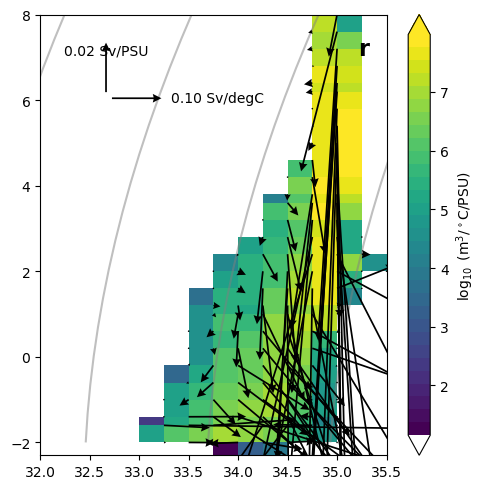

In [70]:
# Define constants
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, .1, 0.7e0
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
# timestr = datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y")
timestr = datetimes[0].strftime("%m") + "-" +datetimes[0].strftime("%Y")
# timestr = "2010"

# Plot limits
xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 8])

# Titles for each subplot
titles = [
    "Total Tendency", "Advective Tend.", "Diffusive Tend.", "Surface Tend.",
]

# Figure setup
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,np.log10(nanmean_array).T,cmap=cmap2)

# load the vectors we want to plot
U1, V1 = U_all[0].T,V_all[0].T
U1, V1 = U1 * alpha, V1 * beta
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

# Quiver plot
q = ax.quiver(Sbincentp, Tbincentp, 
              U1, V1, 
              width=0.005, scale=scale, zorder=3, headwidth=5)

# Colorbar
plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$',extend="both")

# Titles, limits, and labels
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Quiver key (for scale reference)
ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha:.2f} Sv/degC", labelpos='E')
ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta:.2f} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

# Label each subplot (A, B, C, etc.)
ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
        va='top', ha='right')

# Density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Save figure
plt.tight_layout()
# plt.savefig(path + titlestr + "full" + timestr + ".png", dpi=300)
plt.show()

In [1]:
# Define constants
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, 1, 1e1
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
# timestr = datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y")
timestr = datetimes[0].strftime("%m") + "-" +datetimes[0].strftime("%Y")
timestr = datetimes[0].strftime("%m %Y") + "-" +datetimes[-2].strftime("%m %Y")

# timestr = "2010"

# Plot limits
xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 8])
xlims, ylims = np.array([31, 36]), np.array([-5, 13])

# Titles for each subplot
titles = [
    "Total Tendency", "Advective Tend.", "Diffusive Tend.", "Surface Tend."
]

# Figure setup
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x3 subplot layout
axes = axes.flatten()  # Flatten to iterate easily

for i, ax in enumerate(axes):
    U1,V1 = U_all[i].T,V_all[i].T

    # Apply scaling and set zero values to NaN
    U1, V1 = U1 * alpha, V1 * beta
    U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

    # Background colormap
    # cb = ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib[name]).T,cmap=cmap2)
    cb = ax.pcolormesh(Sbin,Tbin,np.log10(nanmean_array).T,cmap=cmap2)
    
    q = ax.quiver(Sbincentp, Tbincentp, 
                  U1, V1, 
                  width=0.005, scale=scale, zorder=3, headwidth=5)

    # Colorbar
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$',extend="both",vmin=0.01,vmax=8)

    # Titles, limits, and labels
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Quiver key (for scale reference)
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha:.2f} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta:.2f} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Save figure
plt.tight_layout()
plt.savefig("samplelayers_Lind_03_07.png", dpi=300)
plt.show()

NameError: name 'datetimes' is not defined

# compare the G terms to the previous G terms we plotted to see

not sure if we should compare this to the ASTE R1 or the new version...

In [60]:
vol_mesh_all = np.zeros((tsteps,nS,nT))
JtermsT_all = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all = np.zeros((tsteps,5,nS,nT))

In [116]:
iB = 6
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,msk_tobin,iB,RAC,RAC3,myparms)

    vol_mesh_all[i] = vol_mesh
    JtermsT_all[i] = JtermsT
    JtermsS_all[i] = JtermsS
    JtermsT_nn_all[i] = JtermsT_nn
    JtermsS_nn_all[i] = JtermsS_nn

2007-09-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 1.839778194156691e-13 Sv/PSU
doing JtermsS
total residual 1.7852855467918826e-12 Sv/degC
doing not normalized J terms
total residual 1.839778194156691e-13 Sv
total residual 1.7852855467918826e-12 Sv


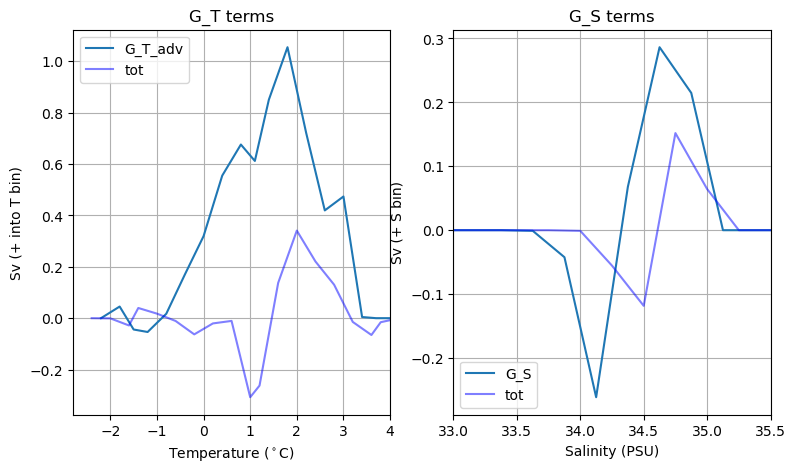

In [78]:
fig = plt.figure(figsize = (9,5))

# M_T at the gates
ax1 = plt.subplot(121)
# add lines for the monthly mean values from ASTER1
ax1.plot(binmidT[1:],np.nansum(JtermsT_nn_all[0][1],axis=0)[1:],label="G_T_adv",alpha=1)
# ax1.plot(binmidT,np.nansum(JtermsT_nn_all[0][2],axis=0),label="G_T_df",alpha=1)
# ax1.plot(binmidT,np.nansum(JtermsT_nn_all[0][3],axis=0),label="G_T_conv",alpha=1)
# ax1.plot(binmidT,np.nansum(JtermsT_nn_all[0][4],axis=0),label="G_T_surf",alpha=1)
# ax1.plot(binmidT,np.nansum(JtermsT_nn_all[0][0],axis=0),label="G_T",alpha=1)

# add the layers diagnostics
ax1.plot(binmidTp[:,0,0], G_T[name]["LTto2TH"], 'b-', alpha=0.5, label="tot")
# ax1.plot(binmidTp[:,0,0], G_T[name]["LTza2TH"] + G_T[name]["LTha2TH"], 'r-', alpha=0.5, label="adv")
# ax1.plot(binmidTp[:,0,0], G_T[name]["LaTz2TH"] + G_T[name]["LaTh2TH"], 'g-', alpha=0.5, label="diff")
# ax1.plot(binmidTp[:,0,0], G_T[name]["LaTs2TH"], 'c-', alpha=0.5, label="surf")
# ax1.plot(binmidTp[:,0,0], G_T[name]["residT"], 'k-', alpha=0.5, label="resid")

ax1.set_xlim(-2.8,4)
ax1.legend(loc="upper left")
ax1.grid()
ax1.set_title("G_T terms")
ax1.set_ylabel("Sv (+ into T bin)")
ax1.set_xlabel(r"Temperature ($^\circ$C)")

# M_S at the gates
ax2 = plt.subplot(122)
# add lines for the monthly mean values from ASTER1
# ax2.plot(binmidS,np.nansum(JtermsS_nn_all[0][1],axis=1),label="G_S_adv",alpha=1)
# ax2.plot(binmidS,np.nansum(JtermsS_nn_all[0][2],axis=1),label="G_S_df",alpha=1)
# ax2.plot(binmidS,np.nansum(JtermsS_nn_all[0][3],axis=1),label="G_S_conv",alpha=1)
# ax2.plot(binmidS,np.nansum(JtermsS_nn_all[0][4],axis=1),label="G_S_surf",alpha=1)
ax2.plot(binmidS,np.nansum(JtermsS_nn_all[0][0],axis=1),label="G_S",alpha=1)
# add the layers diagnostics
ax2.plot(binmidSp[:,0,0], G_S[name]["LSto1SLT"], 'b-', alpha=0.5, label="tot")
# ax2.plot(binmidSp[:,0,0], G_S[name]["LSza1SLT"] + G_S[name]["LSha1SLT"], 'r-', alpha=0.5, label="adv")
# ax2.plot(binmidSp[:,0,0], G_S[name]["LaSz1SLT"] + G_S[name]["LaSh1SLT"], 'g-', alpha=0.5, label="diff")
# ax2.plot(binmidSp[:,0,0], G_S[name]["LaSs1SLT"], 'c-', alpha=0.5, label="surf")
# ax2.plot(binmidSp[:,0,0], G_S[name]["residS"], 'k-', alpha=0.5, label="resid")

ax2.set_xlim(33,35.5)
ax2.legend(loc="upper left")
ax2.grid()
ax2.set_title("G_S terms")
ax2.set_ylabel("Sv (+ S bin)")
ax2.set_xlabel(r"Salinity (PSU)")
ax2.legend(loc="lower left")

plt.subplots_adjust(hspace = 0.5)

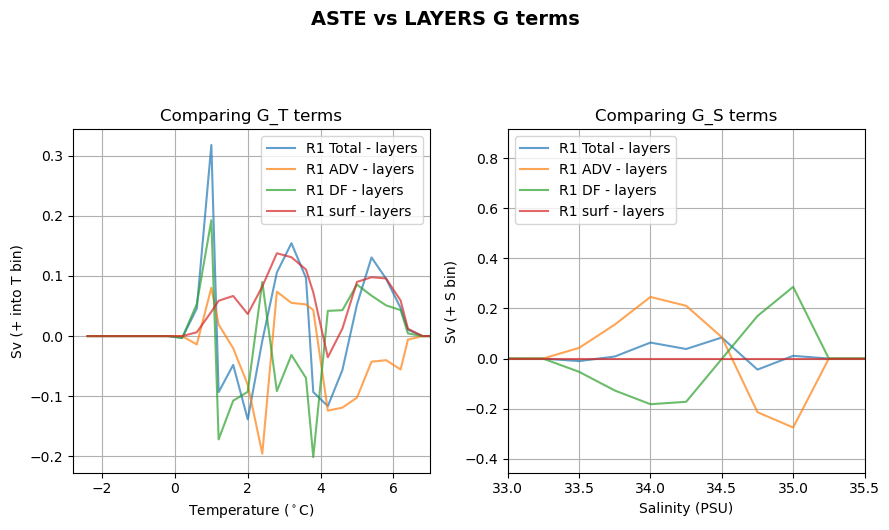

In [121]:
# maybe just plot the difference between them

fig = plt.figure(figsize = (9,5))

# M_T at the gates
ax1 = plt.subplot(121)
# add lines for the monthly mean values from ASTER1
ax1.plot(binmidTp[:,0,0],np.nansum(JtermsT_nn_all[0][0],axis=0)[:-1] - G_T[name]["LTto2TH"],label="R1 Total - layers",alpha=.7)
ax1.plot(binmidTp[:,0,0],np.nansum(JtermsT_nn_all[0][1],axis=0)[:-1] - (G_T[name]["LTza2TH"] + G_T[name]["LTha2TH"]),label="R1 ADV - layers",alpha=.7)
ax1.plot(binmidTp[:,0,0],np.nansum(JtermsT_nn_all[0][2],axis=0)[:-1] - (G_T[name]["LaTz2TH"] + G_T[name]["LaTh2TH"]),label="R1 DF - layers",alpha=.7)
ax1.plot(binmidTp[:,0,0],np.nansum(JtermsT_nn_all[0][4],axis=0)[:-1] - (G_T[name]["LaTs2TH"]),label="R1 surf - layers",alpha=.7)

ax1.set_xlim(-2.8,7)
ax1.legend(loc="upper right")
ax1.grid()
ax1.set_title("Comparing G_T terms")
ax1.set_ylabel("Sv (+ into T bin)")
ax1.set_xlabel(r"Temperature ($^\circ$C)")

# M_S at the gates
ax2 = plt.subplot(122)
# add lines for the monthly mean values from ASTER1
ax2.plot(binmidSp[:,0,0],np.nansum(JtermsT_nn_all[0][0],axis=0)[:-1] - G_S[name]["LSto1SLT"],label="R1 Total - layers",alpha=.7)
ax2.plot(binmidSp[:,0,0],np.nansum(JtermsT_nn_all[0][1],axis=0)[:-1] - (G_S[name]["LSza1SLT"] + G_S[name]["LSha1SLT"]),label="R1 ADV - layers",alpha=.7)
ax2.plot(binmidSp[:,0,0],np.nansum(JtermsT_nn_all[0][2],axis=0)[:-1] - (G_S[name]["LaSz1SLT"] + G_S[name]["LaSh1SLT"]),label="R1 DF - layers",alpha=.7)
ax2.plot(binmidSp[:,0,0],np.nansum(JtermsT_nn_all[0][4],axis=0)[:-1] - (G_S[name]["LaSs1SLT"]),label="R1 surf - layers",alpha=.7)

ax2.set_xlim(33,35.5)
ax2.legend(loc="upper left")
ax2.grid()
ax2.set_title("Comparing G_S terms")
ax2.set_ylabel("Sv (+ S bin)")
ax2.set_xlabel(r"Salinity (PSU)")
# ax2.legend(loc="lower left")

plt.suptitle("ASTE vs LAYERS G terms", fontsize=14, fontweight='bold', y=1.05)

# Adjust layout before saving
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ensures suptitle has space

# Save without cropping

plt.subplots_adjust(hspace = 0.5)

plt.savefig("CompareG_TERMS_sept2007.png", bbox_inches='tight')